# Piqasso Part II: MSD State Encoding & Steane QEC

**QuEra iQuHack 2026 — Step 2**

This notebook implements:
1. **MSD State Encoding circuit** — Encode a state into the [[7,1,3]] (Steane/color) code, following QuEra's magic-state distillation work.
2. **Steane QEC** — One round of syndrome extraction: measure the six stabilizers of the [[7,1,3]] code and read out the syndrome.

References: [QuEra MSD (2412.15165)](https://arxiv.org/abs/2412.15165), [Steane QEC (2312.09745)](https://arxiv.org/pdf/2312.09745).

## 1. Setup

Install dependencies (run once; on Colab: **Runtime → Restart session** after). Then import Bloqade (Squin), Cirq interop, and Stim.

In [1]:
!pip install -q numpy cirq "bloqade-circuit[cirq,stim,tsim]>=0.11.0"
print("Done. On Colab: Runtime -> Restart session, then run the rest.")

Done. On Colab: Runtime -> Restart session, then run the rest.


  error: subprocess-exited-with-error
  
  × Building wheel for stim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating python_build_stim\lib.win-amd64-cpython-313\stim
      copying glue\python\src\stim\_main_argv.py -> python_build_stim\lib.win-amd64-cpython-313\stim
      copying glue\python\src\stim\__init__.py -> python_build_stim\lib.win-amd64-cpython-313\stim
      running egg_info
      writing stim.egg-info\PKG-INFO
      writing dependency_links to stim.egg-info\dependency_links.txt
      writing entry points to stim.egg-info\entry_points.txt
      writing requirements to stim.egg-info\requires.txt
      writing top-level names to stim.egg-info\top_level.txt
      reading manifest file 'stim.egg-info\SOURCES.txt'
      reading manifest template 'MANIFEST.in'
      adding license file 'LICENSE'
      writing manifest file 'stim.egg-info\SOURCES.txt'
      cop

In [1]:
from typing import Literal
import numpy as np
from bloqade import squin
from bloqade.types import Qubit
from kirin.dialects import ilist
from math import pi
import bloqade.stim
import bloqade.tsim
from bloqade.cirq_utils import load_circuit
from bloqade.cirq_utils.emit import emit_circuit

## 2. Magic State Preparation and Injection

Prepare the MSD circuit by introducing a magic state and injecting it into the 7 qubit code

In [25]:
@squin.kernel
def magicstateprep(qubits, ind):
    squin.t(qubits[ind])


def mapping_f(n):
    dicti = {0: 1, 1: 3, 2: 7, 3: 6, 4: 2, 5: 5, 6: 4}


@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    squin.reset(q[0:2])
    squin.reset(q[2:7])
    magicstateprep(q, 2)
    # ry(-pi/2) on old 0..5  ->  new [3,1,0,6,4,5]
    for j in (3, 1, 0, 6, 4, 5):
        squin.ry(-pi / 2, q[j])

    # cz(1,2), cz(3,4), cz(5,6) -> cz(1,0), cz(6,4), cz(5,2)
    squin.cz(q[1], q[0])
    squin.cz(q[6], q[4])
    squin.cz(q[5], q[2])

    # ry on old 6 -> new 2
    squin.ry(pi / 2, q[2])

    # cz(0,3), cz(2,5), cz(4,6) -> cz(3,6), cz(0,5), cz(4,2)
    squin.cz(q[3], q[6])
    squin.cz(q[0], q[5])
    squin.cz(q[4], q[2])

    # ry on old 2..6 -> new [0,6,4,5,2]
    for j in (0, 6, 4, 5, 2):
        squin.ry(pi / 2, q[j])

    # cz(0,1), cz(2,3), cz(4,5) -> cz(3,1), cz(0,6), cz(4,5)
    squin.cz(q[3], q[1])
    squin.cz(q[0], q[6])
    squin.cz(q[4], q[5])

    # final single-qubit ry: old 1 -> 1, old 2 -> 0, old 4 -> 4
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[0])
    squin.ry(pi / 2, q[4])
    squin.z(q[3])
    squin.x(q[0])
    squin.x(q[1])
    squin.x(q[3])


@squin.kernel
def main():
    """Wrapper: allocate 7 qubits and run injection (for emit_circuit without args)."""
    q = squin.qalloc(7)
    injection(q)

and let's look at what our circuit looks like

In [26]:
# Injection only (7 qubits) — use wrapper kernel since injection(q) takes a parameter
cirq_diagram = emit_circuit(main)
squin_for_diagram = load_circuit(cirq_diagram)
tsim_circ = bloqade.tsim.Circuit(squin_for_diagram)
fig = tsim_circ.diagram(height=400)
fig

### 2.1 Steane encoding and A3 circuit (from a3.ipynb)

This block adds the **Steane [[7,1,3]] encoding** (|0⟩_L and |+⟩_L) and the full **A3 circuit**: magic-state injection on 7 data qubits, then X-syndrome extraction (ancilla |+⟩_L), then Z-syndrome extraction (ancilla |0⟩_L), then measure all 14 ancillas.

In [ ]:
# ---------------------------------------------------------------------------
# Steane [[7,1,3]] Encoding (a3.ipynb 119-140)
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode |0⟩^7 → |0⟩_L on the 7-qubit register q (Steane [[7,1,3]])."""
    squin.h(q[0])
    squin.h(q[1])
    squin.h(q[3])
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])


@squin.kernel
def steane_encode_plus_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode 7 qubits as |+⟩_L: first |0⟩_L then transversal H."""
    steane_encode_zero_on(q)
    for i in range(7):
        squin.h(q[i])


# ---------------------------------------------------------------------------
# A3 Circuit: Fault-tolerant Steane syndrome extraction (a3.ipynb 146-180)
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit():
    """A3 circuit implementation in squin."""
    q = squin.qalloc(21)

    injection(q)
    # Qubits 0-6: logical data; Qubits 7-14 + 15-21: ancilla block

    # Prepare ancilla as |+⟩_L for first half (X-stabilizer syndrome)
    steane_encode_plus_on(q[7:14])

    # CNOTs: data → ancilla (X-syndrome extraction)
    for i in range(7):
        squin.cx(q[i], q[i + 7])

    # Prepare ancilla as |0⟩_L for second half (Z-stabilizer syndrome)
    steane_encode_zero_on(q[14:21])

    # CNOTs: ancilla → data (Z-syndrome extraction)
    for i in range(7):
        squin.cx(q[i + 14], q[i])

    # Transversal H on ancilla
    for i in range(7):
        squin.h(q[i + 14])

    # Measure ancilla qubits 7-21 (Syndrome bits)
    for i in range(7, 21):
        squin.measure(q[i])

### 2.2 Ancillas and syndrome-check helpers (from a3)

The A3 circuit measures **14 ancilla qubits** (two blocks of 7) to extract the **six stabilizer syndromes** of the Steane [[7,1,3]] code: three X-type and three Z-type. Each syndrome is a parity check over specific physical qubits.

- **`synd_dict`**: Maps stabilizer label → 1-based qubit indices for that stabilizer (Steane: [1,3,5,7], [4,5,6,7], [2,3,6,7]).
- **`to_parity`**: Converts measurement bits (0/1) to ±1 for parity product.
- **`find_syndrome`**: Returns whether one stabilizer is satisfied (product = +1) for a 7-bit block.
- **`findZSyndrome` / `findXSyndrome`**: Apply the check to the first 7 (Z-ancilla) or next 7 (X-ancilla) bits of a 14-bit sample.
- **`compute_syndromes`**: Returns (x_synds, z_synds)—three X and three Z syndrome bits per shot.
- **`find_good_rate`**: Fraction of shots where **all six** syndromes are satisfied (no detected error).

In [29]:
# Steane [[7,1,3]] stabilizer indices (1-based): which ancilla bits enter each parity check
synd_dict = {1: [1, 3, 5, 7], 2: [4, 5, 6, 7], 3: [2, 3, 6, 7]}


def to_parity(li):
    """Convert measurement bits to ±1 for parity product. False→+1, True→-1."""
    return [-2 * el + 1 for el in li]


def find_syndrome(li, idx):
    """Return True if the stabilizer (qubit indices idx, 1-based) is satisfied for 7-bit block li."""
    li = to_parity(li)
    mult = 1
    for ind in idx:
        mult *= li[ind - 1]
    return mult == 1


def findZSyndrome(sample, idx):
    """Z-syndrome from first 7 measurement bits (first ancilla block)."""
    return find_syndrome(sample[0:7], idx)


def findXSyndrome(sample, idx):
    """X-syndrome from next 7 measurement bits (second ancilla block)."""
    return find_syndrome(sample[7:14], idx)


def compute_syndromes(sample, ind_dict):
    """Return (x_synds, z_synds): each is a list of 3 booleans (one per stabilizer)."""
    x_synds, z_synds = [], []
    for key in list(ind_dict.keys()):
        idx = ind_dict[key]
        x_synds.append(findXSyndrome(sample, idx))
        z_synds.append(findZSyndrome(sample, idx))
    return x_synds, z_synds


def find_good_rate(samples, ind_dict, verbose=False):
    """Fraction of shots with all 6 syndromes satisfied (no detected error). Matches a3.ipynb."""
    good_samples = 0
    for j, sample in enumerate(samples):
        synd = compute_syndromes(sample, ind_dict)
        if verbose:
            print(j, synd)
        if np.count_nonzero(synd) == 6:
            good_samples += 1
    return good_samples / len(samples) if len(samples) else 0.0

### 2.3 Sanity Checking

**What we are searching for**

1. **Logical consistency**: For the ideal (noiseless) A3 circuit, every shot should have **all six stabilizer syndromes satisfied**. That means: for each shot, the 14 ancilla measurement bits are split into two blocks of 7; we compute 3 X-syndromes and 3 Z-syndromes via parity checks. We expect **all 6 to be True** (product +1) when there is no error.
2. **Fidelity (good rate)**: The fraction of shots with all 6 syndromes satisfied. For a correct, noiseless implementation we expect **fidelity ≈ 1.0**.
3. **Syndrome distribution**: How many shots have 0, 1, …, 6 syndromes satisfied. We expect almost all shots at 6 when there is no noise.
4. **Raw vs syndrome-based**: Raw measurement error rate (fraction of bits that are 1) can be nonzero; the **syndrome-good rate** is the meaningful check that the logical state is correct. 

In [30]:
# Steane encoding and a3_circuit are defined in section 2.2 (Part 2).
# Below: a3extraction and executiona3 only.


@squin.kernel
def a3extraction(data: ilist.IList[Qubit, Literal[7]], ancilla: ilist.IList[Qubit, Literal[7]]):
    """Full fault-tolerant Steane EC cycle: 14 qubits (7 data + 7 ancilla). First half: ancilla |+⟩_L, CNOT data→ancilla, measure (X-syndrome), reset. Second half: ancilla |0⟩_L, CNOT ancilla→data, H on ancilla, measure (Z-syndrome)."""
    steane_encode_plus_on(ancilla)
    for i in range(7):
        squin.cx(data[i], ancilla[i])
    squin.broadcast.measure(ancilla)
    squin.broadcast.reset(ancilla)
    steane_encode_zero_on(ancilla)
    for i in range(7):
        squin.cx(ancilla[i], data[i])
    for i in range(7):
        squin.h(ancilla[i])
    squin.broadcast.measure(ancilla)


@squin.kernel
def executiona3():
    """Sequential: (1) inject magic state into 7 data qubits; (2) run a3 extraction on that data + 7 ancillas."""
    q = squin.qalloc(7)
    injection(q)
    ancilla = squin.qalloc(7)
    a3extraction(q, ancilla)

Before we proceed any further, let's check to make sure that our syndrome extraction is valid. We do not introduce any noise into our system so we should have full fidelity.

In [12]:
# a3_circuit is defined in section 2.2 (Part 2). Run cells in order so it is available here.

### 2.4 Graphing

**What we are searching for**

1. **Logical consistency**: For the ideal (noiseless) A3 circuit, every shot should have **all six stabilizer syndromes satisfied**. That means:
   - For each shot, the 14 ancilla measurement bits are split into two blocks of 7; we compute 3 X-syndromes and 3 Z-syndromes via parity checks. We expect **all 6 to be True** (product +1) when there is no error.
2. **Fidelity (good rate)**: The fraction of shots with all 6 syndromes satisfied. For a correct, noiseless implementation we expect **fidelity ≈ 1.0**.
3. **Syndrome distribution**: How many shots have 0, 1, …, 6 syndromes satisfied. We expect almost all shots at 6 when there is no noise.
4. **Raw vs syndrome-based**: Raw measurement error rate (fraction of bits that are 1) can be nonzero due to the magic state; the **syndrome-good rate** is the meaningful check that the logical state is correct.

In [31]:
cirq_enc = emit_circuit(a3_circuit)
squin_enc = load_circuit(cirq_enc)
stim_enc = bloqade.stim.Circuit(squin_enc)
fig = stim_enc.diagram()
sampler = stim_enc.compile_sampler()
samples_enc = np.array(sampler.sample(shots=10))

print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
print("Sample shape:", samples_enc.shape)
print("First 5 shots:\n", samples_enc[:5])
print(np.count_nonzero(samples_enc)/len(samples_enc))
fig

MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)
Sample shape: (10, 14)
First 5 shots:
 [[False  True False False  True False  True False False False  True  True
   True  True]
 [ True False False  True  True False False  True False  True  True False
   True False]
 [ True False False  True  True False False False False  True False  True
   True False]
 [False  True  True False False  True  True  True False False  True  True
  False False]
 [ True  True  True False False False False  True False  True False  True
  False  True]]
7.6


q0: -R-SQRT_Y_DAG---@----------------@-SQRT_Y---------------@-SQRT_Y-----X----------------@---------X----------------------------
                     |                |                      |                             |         |
 q1: -R-SQRT_Y_DAG---@----------------|--------@-------------|-SQRT_Y-X----------@---------|---X-----|----------------------------
                                      |        |             |                   |         |   |     |
 q2: -R-S--------------@-------SQRT_Y-|-@------|------SQRT_Y-|----------@--------|-----X---|---|-----|----------------------------
                       |              | |      |             |          |        |     |   |   |     |
 q3: -R-SQRT_Y_DAG-----|-------@------|-|------@-------------|-Z------X-|--------|-@---|---|---|-X---|----------------------------
                       |       |      | |                    |          |        | |   |   |   | |   |
 q4: -R-SQRT_Y_DAG---@-|-------|------|-@------SQRT_Y--------|-@--------|-SQRT_Y-|-|---|---|-@-|-|---|-X--------------------------
                     | |       |      |                      | |        |        | |   |   | | | |   | |
 q5: -R-SQRT_Y_DAG---|-@-------|------@-SQRT_Y---------------|-@--------|--------|-|-@-|---|-|-|-|-X-|-|--------------------------
                     |         |                             |          |        | | | |   | | | | | | |
 q6: -R-SQRT_Y_DAG---@---------@--------SQRT_Y---------------@----------|-@------|-|-|-|-X-|-|-|-|-|-|-|--------------------------
                                                                        | |      | | | | | | | | | | | |
 q7: -H-@--------------@--------------@--------H------------------------|-|------|-|-|-|-|-X-|-|-|-|-|-|-M(0):rec[0]--------------
        |              |              |                                 | |      | | | | |   | | | | | |
 q8: -H-|----------@---|---@----------|-H-------------------------------|-|------X-|-|-|-|---|-|-|-|-|-|-M(0):rec[1]--------------
        |          |   |   |          |                                 | |        | | | |   | | | | | |
 q9: ---|----------X---|---|----------X--------H------------------------X-|--------|-|-|-|---|-|-|-|-|-|-M(0):rec[2]--------------
        |              |   |                                              |        | | | |   | | | | | |
q10: -H-|----------@---|-@-|------------H---------------------------------|--------X-|-|-|---|-|-|-|-|-|-M(0):rec[3]--------------
        |          |   | | |                                              |          | | |   | | | | | |
q11: ---X----------|---|-X-|------------H---------------------------------|----------|-|-|---X-|-|-|-|-|-M(0):rec[4]--------------
                   |   |   |                                              |          | | |     | | | | |
q12: --------------X---|---X----------@--------H--------------------------|----------X-|-|-----|-|-|-|-|-M(0):rec[5]--------------
                       |              |                                   |            | |     | | | | |
q13: ------------------X--------------X--------H--------------------------X------------|-|-----|-|-|-|-|-M(0):rec[6]--------------
                                                                                       | |     | | | | |
q14: -H------------@-------@------------@----------------------------------------------|-|-----|-|-|-@-|-H-----------M(0):rec[7]--
                   |       |            |                                              | |     | | |   |
q15: -H------------|-@-----|---@--------|----------------------------------------------|-|-----@-|-|---|-H-----------M(0):rec[8]--
                   | |     |   |        |                                              | |       | |   |
q16: --------------|-X-----|---|--------X----------------------------------------------@-|-------|-|-H-|-------------M(0):rec[9]--
                   |       |   |                                                         |       | |  

In [32]:
# Run A3 with more shots for sanity checks and fidelity stats (helpers from section 2.4)
import matplotlib.pyplot as plt

SANITY_SHOTS = 1000
cirq_enc_sc = emit_circuit(a3_circuit)
squin_enc_sc = load_circuit(cirq_enc_sc)
stim_enc_sc = bloqade.stim.Circuit(squin_enc_sc)
sampler_sc = stim_enc_sc.compile_sampler()
samples_sanity = np.array(sampler_sc.sample(shots=SANITY_SHOTS))

good_rate = find_good_rate(samples_sanity, synd_dict, verbose=False)

def _n_satisfied(s, ind_dict):
    xs, zs = compute_syndromes(s, ind_dict)
    return np.sum(xs) + np.sum(zs)

n_satisfied_per_shot = [_n_satisfied(s, synd_dict) for s in samples_sanity]
raw_error_rate = np.count_nonzero(samples_sanity) / samples_sanity.size

print("What we are checking: all 6 syndromes satisfied = no detected error.")
print(f"Shots: {SANITY_SHOTS}  |  Fidelity (good rate): {good_rate:.4f}  |  Raw bit error rate: {raw_error_rate:.4f}")
print(f"Good shots (all 6 satisfied): {sum(1 for n in n_satisfied_per_shot if n == 6)}")

What we are checking: all 6 syndromes satisfied = no detected error.
Shots: 1000  |  Fidelity (good rate): 1.0000  |  Raw bit error rate: 0.5019
Good shots (all 6 satisfied): 1000


In [50]:
# ---------------------------------------------------------------------------
# Plotting methods (distilled from 2.5, 2.6.1.5, 2.6.2)
# ---------------------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_fidelity_bar(good_rate, title="Fidelity (good rate)", ylabel="Fraction of shots with all 6 syndromes satisfied", bar_label="Fidelity\n(good rate)", figsize=(4, 3)):
    """Single bar: fidelity (good rate)."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar([bar_label], [good_rate], color="steelblue", edgecolor="black")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_syndrome_distribution(n_satisfied_per_shot, title="Syndrome distribution (0-6 satisfied)", figsize=(6, 3)):
    """Histogram: number of shots with 0, 1, ..., 6 syndromes satisfied."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    counts, _ = np.histogram(n_satisfied_per_shot, bins=np.arange(8) - 0.5)
    ax.bar(range(7), counts, color="teal", edgecolor="black")
    ax.set_xticks(range(7))
    ax.set_xlabel("Number of syndromes satisfied (out of 6)")
    ax.set_ylabel("Number of shots")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_fidelity_vs_shots(shot_counts, fidelities, title="Fidelity vs shot count (stability check)", figsize=(5, 3)):
    """Line plot: fidelity (good rate) vs number of shots."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(shot_counts, fidelities, "o-", color="darkgreen")
    ax.set_xlabel("Number of shots")
    ax.set_ylabel("Fidelity (good rate)")
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_kept_vs_discarded(n_kept, n_total, title="Kept vs discarded", kept_label="Kept", discarded_label="Discarded", figsize=(5, 3)):
    """Two bars: fraction kept and fraction discarded (e.g. flag behavior)."""
    frac_kept = n_kept / n_total
    frac_discarded = 1.0 - frac_kept
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar([kept_label, discarded_label], [frac_kept, frac_discarded], color=["steelblue", "coral"], edgecolor="black")
    ax.set_ylabel("Fraction of shots")
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_flag_outcome_binary(n_kept, n_discarded, title="Flag outcome distribution", figsize=(5, 3)):
    """Two bars: counts for flag=0 (keep) and flag=1 (discard)."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar([0, 1], [n_kept, n_discarded], color=["green", "red"], edgecolor="black")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Flag=0 (keep)", "Flag=1 (discard)"])
    ax.set_ylabel("Number of shots")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_flag_trigger_distribution(n_flags_triggered_per_shot, max_val=2, title="Flag trigger distribution (0 = keep, 1 or 2 = discard)", figsize=(5, 3)):
    """Histogram: number of shots with 0, 1, ..., max_val flags triggered."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    counts, _ = np.histogram(n_flags_triggered_per_shot, bins=np.arange(max_val + 2) - 0.5)
    colors = ["green", "orange", "red"][: max_val + 1]
    ax.bar(range(max_val + 1), counts, color=colors, edgecolor="black")
    ax.set_xticks(range(max_val + 1))
    ax.set_xlabel("Number of flags triggered")
    ax.set_ylabel("Number of shots")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


Now let us render the graphs. We plot: (1) **Fidelity** — fraction of shots with all 6 syndromes satisfied; (2) **Syndrome distribution** — how many shots have 0, 1, …, 6 syndromes satisfied (we expect almost all at 6 for noiseless); (3) **Fidelity vs number of shots** — good rate over increasing shot counts (stability).

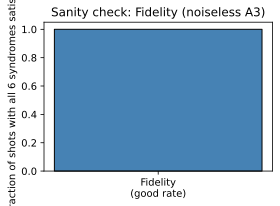

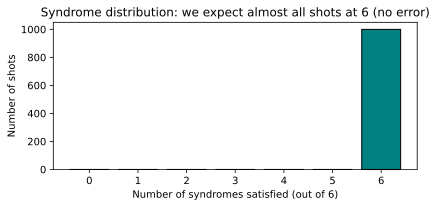

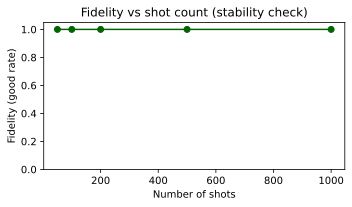

In [51]:
# Use plotting methods (defined in section 2.5)
shot_sweep = [50, 100, 200, 500, min(1000, len(samples_sanity))]
shot_sweep = [n for n in shot_sweep if n <= len(samples_sanity)]
fidelities_vs_shots = [find_good_rate(samples_sanity[:n], synd_dict, verbose=False) for n in shot_sweep]

plot_fidelity_bar(good_rate, title="Sanity check: Fidelity (noiseless A3)")
plot_syndrome_distribution(n_satisfied_per_shot, title="Syndrome distribution: we expect almost all shots at 6 (no error)")
plot_fidelity_vs_shots(shot_sweep, fidelities_vs_shots, title="Fidelity vs shot count (stability check)")

The printed fidelity (good rate) and the graphs above confirm that the checking algorithm is valid: we expect fidelity ≈ 1.0 and almost all shots at 6 satisfied syndromes when the circuit is noiseless.

### 2.6 Flag qubits

We use **one flag qubit per Steane encode**, and we **latch before the encode** so the flag is triggered only when something goes wrong. The ancilla start in |0⟩^7; we apply **CX** from the **third, fifth, and sixth ancilla qubits** (indices 2, 4, 5) to the flag **before** running the Steane encode. In the ideal case all three are |0⟩, so the flag stays 0. Then we run `steane_encode_zero_on` or `steane_encode_plus_on`. The flag triggers (1) only if one of those qubits was wrong before the encode (e.g. preparation error).

In [41]:
# ---------------------------------------------------------------------------
# Steane encode zero with one flag qubit (3rd, 5th, 6th ancilla → single flag)
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on_with_flags(q: ilist.IList[Qubit, Literal[7]], flag: Qubit):
    """Encode |0⟩^7 → |0⟩_L on q (Steane [[7,1,3]]), then CX from 3rd, 5th, 6th ancilla to one flag."""
    steane_encode_zero_on(q)
    squin.cx(q[2], flag)
    squin.cx(q[4], flag)
    squin.cx(q[5], flag)


# ---------------------------------------------------------------------------
# Steane encode plus with one flag qubit (3rd, 5th, 6th ancilla → single flag)
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_plus_on_with_flags(q: ilist.IList[Qubit, Literal[7]], flag: Qubit):
    """Encode |+⟩_L on q (Steane [[7,1,3]]), then CX from 3rd, 5th, 6th ancilla to one flag."""
    steane_encode_plus_on(q)
    squin.cx(q[2], flag)
    squin.cx(q[4], flag)
    squin.cx(q[5], flag)

In [42]:
# ---------------------------------------------------------------------------
# A3-style circuit with flags (one flag per encode: plus for X-block, zero for Z-block)
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit_with_flags():
    """A3 circuit with flags: 23 qubits (7 data + 7 X-ancilla + 7 Z-ancilla + 2 flags)."""
    q = squin.qalloc(23)
    # Qubits 0-6: data; 7-13: X-ancilla; 14-20: Z-ancilla; 21: flag X; 22: flag Z

    injection(q[0:7])

    # X-syndrome: ancilla |+⟩_L with flag, CNOT data → ancilla
    steane_encode_plus_on_with_flags(q[7:14], q[21])
    for i in range(7):
        squin.cx(q[i], q[i + 7])

    # Z-syndrome: ancilla |0⟩_L with flag (3rd, 5th, 6th Z-ancilla → one flag)
    steane_encode_zero_on_with_flags(q[14:21], q[22])

    # CNOTs: Z-ancilla → data
    for i in range(7):
        squin.cx(q[i + 14], q[i])

    # Transversal H on Z-ancilla
    for i in range(7):
        squin.h(q[i + 14])

    # Measure all syndrome bits (14) and flag bits (2)
    for i in range(7, 23):
        squin.measure(q[i])


@squin.kernel
def executionflaga3():
    """Sequential: run A3 circuit with flags (23 qubits: 7 data + 7 X-ancilla + 7 Z-ancilla + 2 flags). Same role as executiona3 but with flagged encodes."""
    a3_circuit_with_flags()

#### 2.6.1 Circuit with flags

The **A3-style circuit with flags** uses **one flag per encode**: the X-ancilla block uses `steane_encode_plus_on_with_flags` (one flag), and the Z-ancilla block uses `steane_encode_zero_on_with_flags` (one flag). We allocate **23 qubits**: 7 data, 7 X-ancilla, 7 Z-ancilla, 2 flags. At the end we measure all 14 syndrome bits plus the 2 flag bits (16 measurements).

In [46]:
# Emit executionflaga3 (23 qubits with flags) and display diagram (same pattern as executiona3 plot)
cirq_flaga3 = emit_circuit(executionflaga3)
squin_flaga3 = load_circuit(cirq_flaga3)
tsim_flaga3 = bloqade.tsim.Circuit(squin_flaga3)
fig_flaga3 = tsim_flaga3.diagram(height=500)
fig_flaga3

#### 2.6.1.5 One unit: steane_encode_zero_on_with_flags

We run a **single** Steane encode with one flag: 7 ancilla qubits plus 1 flag (8 qubits total). We prepare |0⟩_L on the ancilla block with the flag latching before the encode, then measure all 8 qubits. This isolates the flag behavior for the Z-encode unit. Below we build the circuit, display its diagram, run it, and plot **kept vs. not kept** (and related graphs) using the same evaluation rule: keep a shot only when the flag is 0.

In [47]:
# One unit: 7 ancilla + 1 flag; run steane_encode_zero_on_with_flags, then measure all 8
@squin.kernel
def one_unit_zero_with_flags():
    q = squin.qalloc(8)
    steane_encode_zero_on_with_flags(q[0:7], q[7])
    for i in range(8):
        squin.measure(q[i])

# Emit and display diagram
cirq_one_unit = emit_circuit(one_unit_zero_with_flags)
squin_one_unit = load_circuit(cirq_one_unit)
tsim_one_unit = bloqade.tsim.Circuit(squin_one_unit)
fig_one_unit = tsim_one_unit.diagram(height=400)
fig_one_unit

2.6.1.5 One unit (steane_encode_zero_on_with_flags):
Shots: 1000  |  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000


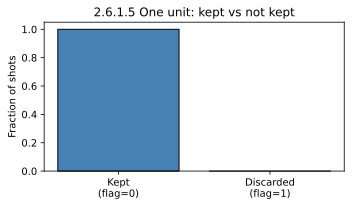

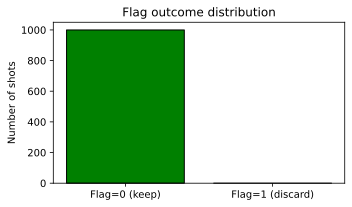

In [ ]:
# Run one-unit circuit and evaluate flag: keep when flag == 0
UNIT_SHOTS = 1000
cirq_one_unit_run = emit_circuit(one_unit_zero_with_flags)
squin_one_unit_run = load_circuit(cirq_one_unit_run)
stim_one_unit = bloqade.stim.Circuit(squin_one_unit_run)
sampler_one_unit = stim_one_unit.compile_sampler()
samples_one_unit = np.array(sampler_one_unit.sample(shots=UNIT_SHOTS))

# Sample layout: 8 columns — 0–6 = ancilla measurements, 7 = flag
flag_col = samples_one_unit[:, 7]
kept_mask_unit = (flag_col == 0)
n_kept_unit = np.sum(kept_mask_unit)
n_discarded_unit = UNIT_SHOTS - n_kept_unit
discard_rate_unit = n_discarded_unit / UNIT_SHOTS

print("2.6.1.5 One unit (steane_encode_zero_on_with_flags):")
print(f"Shots: {UNIT_SHOTS}  |  Kept: {n_kept_unit}  |  Discarded: {n_discarded_unit}  |  Discard rate: {discard_rate_unit:.4f}")

# Graphs: kept vs not kept, and flag outcome distribution
plot_kept_vs_discarded(n_kept_unit, UNIT_SHOTS, title="2.6.1.5 One unit: kept vs not kept", kept_label="Kept\n(flag=0)", discarded_label="Discarded\n(flag=1)")
plot_flag_outcome_binary(n_kept_unit, n_discarded_unit, title="Flag outcome distribution")

#### 2.6.1.6 One unit: steane_encode_plus_on_with_flags

We run a **single** Steane encode with one flag for the **plus** (|+⟩_L) unit: 7 ancilla qubits plus 1 flag (8 qubits total). We prepare |+⟩_L on the ancilla block with the flag, then measure all 8 qubits. Below we build the circuit, display its diagram, run it, and plot **kept vs. not kept** and flag outcome distribution (same evaluation rule: keep a shot only when the flag is 0).

In [ ]:
# One unit (plus): 7 ancilla + 1 flag; run steane_encode_plus_on_with_flags, then measure all 8
@squin.kernel
def one_unit_plus_with_flags():
    q = squin.qalloc(8)
    steane_encode_plus_on_with_flags(q[0:7], q[7])
    for i in range(8):
        squin.measure(q[i])

# Emit and display diagram
cirq_one_unit_plus = emit_circuit(one_unit_plus_with_flags)
squin_one_unit_plus = load_circuit(cirq_one_unit_plus)
tsim_one_unit_plus = bloqade.tsim.Circuit(squin_one_unit_plus)
fig_one_unit_plus = tsim_one_unit_plus.diagram(height=400)
fig_one_unit_plus

In [ ]:
# Run one-unit plus circuit and evaluate flag: keep when flag == 0
UNIT_SHOTS_PLUS = 1000
cirq_one_unit_plus_run = emit_circuit(one_unit_plus_with_flags)
squin_one_unit_plus_run = load_circuit(cirq_one_unit_plus_run)
stim_one_unit_plus = bloqade.stim.Circuit(squin_one_unit_plus_run)
sampler_one_unit_plus = stim_one_unit_plus.compile_sampler()
samples_one_unit_plus = np.array(sampler_one_unit_plus.sample(shots=UNIT_SHOTS_PLUS))

# Sample layout: 8 columns — 0–6 = ancilla measurements, 7 = flag
flag_col_plus = samples_one_unit_plus[:, 7]
kept_mask_unit_plus = (flag_col_plus == 0)
n_kept_unit_plus = np.sum(kept_mask_unit_plus)
n_discarded_unit_plus = UNIT_SHOTS_PLUS - n_kept_unit_plus
discard_rate_unit_plus = n_discarded_unit_plus / UNIT_SHOTS_PLUS

print("2.6.1.6 One unit (steane_encode_plus_on_with_flags):")
print(f"Shots: {UNIT_SHOTS_PLUS}  |  Kept: {n_kept_unit_plus}  |  Discarded: {n_discarded_unit_plus}  |  Discard rate: {discard_rate_unit_plus:.4f}")

# Graphs: kept vs not kept, and flag outcome distribution
plot_kept_vs_discarded(n_kept_unit_plus, UNIT_SHOTS_PLUS, title="2.6.1.6 One unit (plus): kept vs not kept", kept_label="Kept\n(flag=0)", discarded_label="Discarded\n(flag=1)")
plot_flag_outcome_binary(n_kept_unit_plus, n_discarded_unit_plus, title="Flag outcome distribution (plus unit)")

Now let us try this for one unit of the plus operation with flags

In [54]:
# One unit: 7 ancilla + 1 flag; run steane_encode_plus_on_with_flags, then measure all 8
@squin.kernel
def one_unit_plus_with_flags():
    q = squin.qalloc(8)
    steane_encode_plus_on_with_flags(q[0:7], q[7])
    for i in range(8):
        squin.measure(q[i])

# Emit and display diagram
cirq_one_unit_plus = emit_circuit(one_unit_plus_with_flags)
squin_one_unit_plus = load_circuit(cirq_one_unit_plus)
tsim_one_unit_plus = bloqade.tsim.Circuit(squin_one_unit_plus)
fig_one_unit_plus = tsim_one_unit_plus.diagram(height=400)
fig_one_unit_plus

#### 2.6.2 Flag behavior and graphs

**Flag behavior**: We **discard** a shot if any flag qubit is triggered (measured as 1). So we only **keep** shots where both flag bits are 0. Among the kept shots we then compute the usual syndrome good rate (fidelity). This implements the standard flagged-syndrome behavior: measurements are discarded when something is wrong with the flags (e.g. possible hook error or other fault that the flag latched).

Below we run the circuit with flags, apply this discard rule, and plot: (1) **Fraction kept vs discarded**, (2) **Fidelity among kept shots** (good rate on non-discarded data), (3) **Number of flags triggered per shot** (0, 1, or 2).

In [44]:
# Run A3 circuit with flags and collect samples (16 measurements: 14 syndrome + 2 flags)
FLAG_SHOTS = 1000
cirq_flaga3_run = emit_circuit(a3_circuit_with_flags)
squin_flaga3_run = load_circuit(cirq_flaga3_run)
stim_flaga3 = bloqade.stim.Circuit(squin_flaga3_run)
sampler_flaga3 = stim_flaga3.compile_sampler()
samples_flags = np.array(sampler_flaga3.sample(shots=FLAG_SHOTS))

# Flag behavior: discard shot if any flag is triggered (flag bit == 1)
# Sample layout: columns 0-13 = syndrome bits, 14 = flag X, 15 = flag Z (measure order q7..q22)
# Use (flag == 0) not ~flag: samples are 0/1 ints, so ~0 is not boolean False and kept_mask would be wrong.
flag_x = samples_flags[:, 14]
flag_z = samples_flags[:, 15]
kept_mask = (flag_x == 0) & (flag_z == 0)  # keep only when both flags are 0 (ideal: all kept)
n_kept = np.sum(kept_mask)
n_discarded = FLAG_SHOTS - n_kept
discard_rate = n_discarded / FLAG_SHOTS

# Fidelity (good rate) among kept shots only (syndrome bits = first 14 columns)
samples_kept_syndrome = samples_flags[kept_mask][:, 0:14]
good_rate_kept = find_good_rate(samples_kept_syndrome, synd_dict, verbose=False) if n_kept > 0 else 0.0

# Number of flags triggered per shot (0, 1, or 2)
n_flags_triggered = np.sum(samples_flags[:, 14:16], axis=1)

print("Flag behavior: discard shot if any flag is triggered (measurement = 1).")
print(f"Shots: {FLAG_SHOTS}  |  Kept: {n_kept}  |  Discarded: {n_discarded}  |  Discard rate: {discard_rate:.4f}")
print(f"Fidelity among kept shots: {good_rate_kept:.4f}")

Flag behavior: discard shot if any flag is triggered (measurement = 1).
Shots: 1000  |  Kept: 506  |  Discarded: 494  |  Discard rate: 0.4940
Fidelity among kept shots: 1.0000


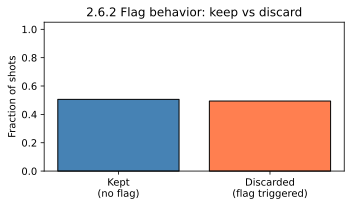

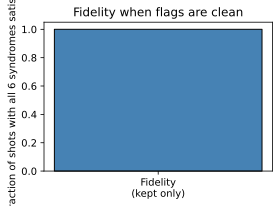

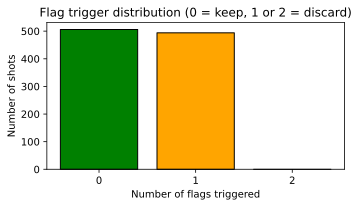

In [53]:
# Use plotting methods (defined in section 2.5)
plot_kept_vs_discarded(n_kept, FLAG_SHOTS, title="2.6.2 Flag behavior: keep vs discard", kept_label="Kept\n(no flag)", discarded_label="Discarded\n(flag triggered)")
plot_fidelity_bar(good_rate_kept, title="Fidelity when flags are clean", bar_label="Fidelity\n(kept only)")
plot_flag_trigger_distribution(n_flags_triggered, max_val=2, title="Flag trigger distribution (0 = keep, 1 or 2 = discard)")

## [Extra] A4 Algorithm Implementation (for later)

Our a3 method follows the circuit for Steane-type syndrome extraction in seven-qubit color code. We can also try implementing **Circuit for flagged syndrome readout for the syndrome extraction on the seven-qubit color code** (especially when we implement flags)

In [14]:
#Implementation of Flagged Syndrome Readout for the Syndrome Extraction
@squin.kernel
def a4extraction(data: ilist.IList[Qubit, Literal[7]],ancilla: ilist.IList[Qubit, Literal[6]]):
    squin.h(ancilla[0])
    squin.h(ancilla[4])
    squin.h(ancilla[5])
    # Part one measuring S_x(1),S_z(2),S_z(3)
    squin.cx(ancilla[0],data[4])
    squin.cx(data[6],ancilla[1])
    squin.cx(data[5],ancilla[2])
    squin.cx(ancilla[0],ancilla[2])
    squin.cx(ancilla[0],data[0])
    squin.cx(data[4],ancilla[1])
    squin.cx(data[1],ancilla[2])
    squin.cx(ancilla[0],data[2])
    squin.cx(data[3],ancilla[1])
    squin.cx(ancilla[0],data[2])
    squin.cx(data[3],ancilla[1])
    squin.cx(data[6],ancilla[2])
    squin.cx(ancilla[0],ancilla[1])
    squin.cx(ancilla[0],data[6])
    squin.cx(data[5],ancilla[1])
    squin.cx(data[2],ancilla[2])
    # Part two measuring S_z(1), S_x(2), S_x(3)
    squin.cx(data[4],ancilla[3])
    squin.cx(ancilla[4],data[6])
    squin.cx(ancilla[5],data[5])
    squin.cx(ancilla[5],ancilla[3])
    squin.cx(data[0],ancilla[3])
    squin.cx(ancilla[4],data[4])
    squin.cx(ancilla[5],data[1])
    squin.cx(data[2],ancilla[3])
    squin.cx(ancilla[4],data[3])
    squin.cx(ancilla[5],data[6])
    squin.cx(ancilla[4],ancilla[3])
    squin.cx(data[6],ancilla[3])
    squin.cx(ancilla[4],data[5])
    squin.cx(ancilla[5],data[2])
    squin.h(ancilla[0])
    squin.h(ancilla[4])
    squin.h(ancilla[5])
    
    for i in range(6):
        squin.broadcast.measure(ancilla[i])

@squin.kernel
def executiona4():
    """Sequential: (1) inject magic state into 7 data qubits; (2) run a3 extraction on that data + 7 ancillas."""
    q = squin.qalloc(7)
    injection(q)
    ancilla = squin.qalloc(6)
    a4extraction(q, ancilla)
    

Now let us perform another sanity check

In [15]:
cirq_a4 = emit_circuit(executiona4)
squin_a4 = load_circuit(cirq_a4)
tsim_a4 = bloqade.tsim.Circuit(squin_a4)
fig_a4 = tsim_a4.diagram(height=500)
fig_a4